In [9]:
import pandas as pd 
from enum import Enum
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
import re
from collections import Counter
from typing import List
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt 

In [10]:
DATASET = '/Users/henrywilliams/Documents/uni/anle/assessment/propaganda_dataset_v2'
train = pd.read_csv(f'{DATASET}/propaganda_train.tsv', sep='\t', header=0, quoting=3)
val = pd.read_csv(f'{DATASET}/propaganda_val.tsv', sep='\t', header=0, quoting=3)

stopwords = stopwords.words('english')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [3]:
set(train['label'])

{'appeal_to_fear_prejudice',
 'causal_oversimplification',
 'doubt',
 'exaggeration,minimisation',
 'flag_waving',
 'loaded_language',
 'name_calling,labeling',
 'not_propaganda',
 'repetition'}

In [4]:
class PropagandaLabel(Enum):
    AppealToFearPrejudice = 1
    CausalOversimplification = 2
    Doubt = 3 
    Exaggeration = 4
    Minimisation = 5
    FlagWaving = 6
    LoadedLanguage = 7
    NameCalling = 8
    Labeling = 9
    NotPropaganda = 10
    Repetition = 11

# Bag Of Words Classifier

In [5]:
def extract_snippet(s: str) -> str:
    start = '<BOS>'
    end = '<EOS>'
    s_idx = s.index(start) + len(start)
    e_idx = s.index(end) 
    return s[s_idx:e_idx]

def is_valid_word(word: str) -> bool: 
    if word is None:
        return False 

    is_stopword = word in stopwords 
    is_alpha = all(c.isalpha() and ord(c) < 128 for c in word)

    return not is_stopword and is_alpha

def process_words(words: List[str], use_lemmatizer=True) -> List[str]:
    """ 
    Preprocess a list of words. Remove all occurances of `None`, stopwords, 
    and words made up of non-alphabetical characters 
    """
    valid_words = list(filter(is_valid_word, words))
    stemmed = map(lemmatizer.lemmatize if use_lemmatizer else stemmer.stem, valid_words)
    return list(stemmed)


# Get all words tagged as propaganda
propaganda_words = [
    word.lower() 
    if label != "not_propaganda" else None
    for _, (label, sample) in train.iterrows() 
    for word in word_tokenize(extract_snippet(sample))
]
words = [
    word.lower() 
    for _, (_, sample) in train.iterrows() 
    for word in word_tokenize(sample)
]

propaganda_words = process_words(propaganda_words)
words = process_words(words)

## Unigram Precision 

In [6]:
from sklearn.linear_model import LogisticRegression

def unigram_precision(words: List[str]) -> float: 
    num_words = len(words)
    common = set(words) & set(propaganda_words)
    return len(common) / num_words

predictions = []
for i, (label, sample) in val.iterrows():
    percentage_correct = unigram_precision(word_tokenize(sample)) 
    predictions.append(percentage_correct)
    
labels = ['propaganda' if label != 'not_propaganda' else 'not_propaganda' for label in val.iloc[:, 0]]
classifier = LogisticRegression() 

train_vals = np.array([unigram_precision(process_words(word_tokenize(sample))) for _, (label, sample) in train.iterrows()])
train_labels = np.array([1.0 if label != 'not_propaganda' else 0.0 for _, (label, _) in train.iterrows()])
train_vals = np.reshape(train_vals, (-1, 1))
train_labels = np.reshape(train_labels, (-1, 1))

classifier.fit(train_vals, train_labels)
predictions = np.zeros_like(val.iloc[:, 0])
predictions = np.reshape(predictions, (-1, 1))

for i, (label, sample) in val.iterrows(): 
    model = np.array([[unigram_precision(process_words(word_tokenize(sample)))]])
    predictions[i] = classifier.predict(model)
gt_labels = [1.0 if label != 'not_propaganda' else 0.0 for label in val.iloc[:, 0]]
gt_labels = np.reshape(gt_labels, (-1, 1)).astype(np.float32)
predictions = predictions.astype(np.float32)
print(classification_report(gt_labels, predictions))

/Users/henrywilliams/Documents/uni/anle/assessment/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


precision    recall  f1-score   support

         0.0       0.61      0.67      0.64       301
         1.0       0.60      0.53      0.56       279

    accuracy                           0.60       580
   macro avg       0.60      0.60      0.60       580
weighted avg       0.60      0.60      0.60       580

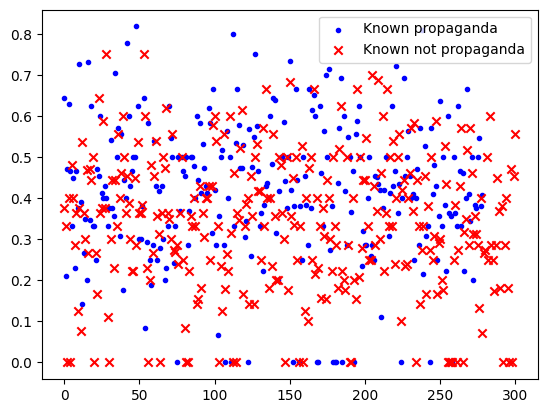

In [7]:
model = np.array([[unigram_precision(process_words(word_tokenize(sample))), 1.0 if label != 'not_propaganda' else 0.0] 
         for i, (label, sample) in val.iterrows()])
propaganda = model[model[:, 1] == 1.]
not_propaganda = model[model[:, 1] == 0.]
plt.scatter(np.arange(len(propaganda[:, 0])), propaganda[:, 0], marker='.', c='b', label="Known propaganda")
plt.scatter(np.arange(len(not_propaganda[:, 0])), not_propaganda[:, 0], marker='x', c='r', label="Known not propaganda")
plt.legend()
plt.show()